In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
cv2.destroyAllWindows()

# Image alteration
in this part we will take the image and modify it more precisely by performing the following steps:
1. remove noise and make the colours purer, so the greens will be greener and therefore easier to isolate
2. binary black-and-white mapping. All green or very green colours (so they will have the Green value high and the others low) will be mapped to white, all others to black

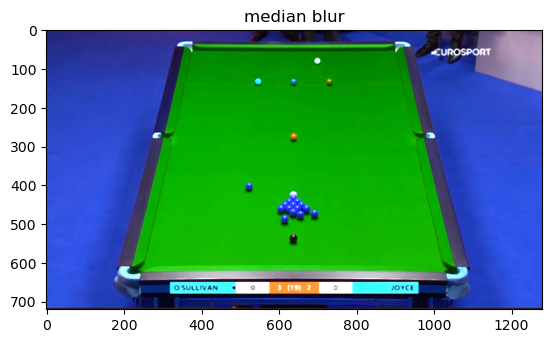

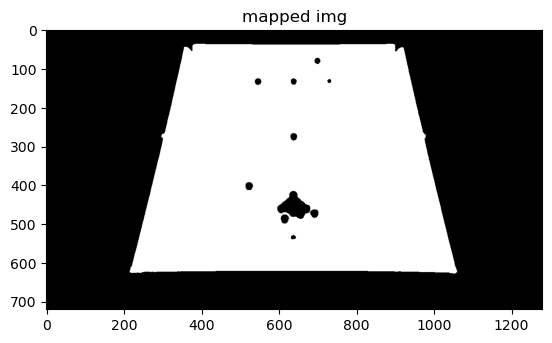

In [2]:
image_path = 'test_image.png'  

image = cv2.imread(image_path)

# ##################################################
# STEP 1: remove noise and make color image more pure 
# ##################################################

# With median blur, the value of the center pixel is replaced by the median of all the pixels in the kernel area.
# this reduces the noise in the image
def custom_median_blur(image, kernel_size):
    padded_image = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0, 0)), mode='reflect')
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                result[i, j, k] = np.median(padded_image[i:i+kernel_size, j:j+kernel_size, k])
    return result


# this function is used to make the image more bright
# increase the value of alpha to make the image more bright
# decrease the value of beta to make the image more bright

def custom_convert_scale_abs(image, alpha, beta):
    result = alpha * image + beta
    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

image = custom_median_blur(image, 5)
image = custom_convert_scale_abs(image, 1.5, 0)

plt.imshow(image)
plt.title('median blur')
plt.show()


# ##################################################
# STEP 2: convert into a binary image black and white 
# ##################################################

# in this function we convert the image into a binary image
# if the value of green component is greater than the red and blue component then we set the pixel to 255
def map_to_gray(image, threshold=1.5):
    mask = (image[:, :, 1] > image[:, :, 0]*threshold) & (image[:, :, 1] > image[:, :, 2]*threshold)
    gray_mapped = np.where(mask, 255, 0)

    return gray_mapped.astype(np.uint8)


image = map_to_gray(image)
plt.imshow(image, cmap='gray')
plt.title('mapped img')
plt.show()


# Edge Detection
in this part we use Canny Edge Detection so we have some phases:
1. sobel filters so we get the edges of the image
2. apply non maximum suppresion: this change the edge of sobel into thinner edges
3. double threshold: identify the res, weak, strong pixels
4. hysteresis transform weak picel to stron pixels

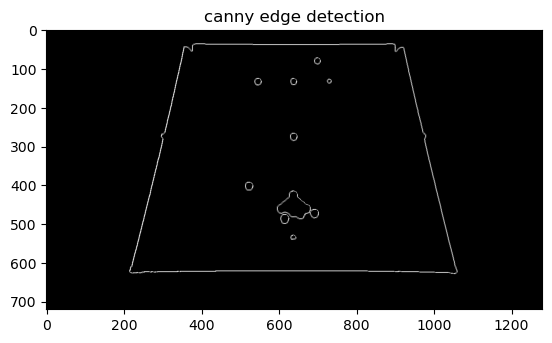

In [3]:

from scipy.ndimage import gaussian_filter, convolve


## ####################################
## ########## SOBEL FILTERS ###########
## ####################################

def sobel_filters(img):
    # filters: Sobel operator
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    # convolution
    Ix = convolve(img, Kx)
    Iy = convolve(img, Ky)
    
    # gradient magnitude
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return G, theta

# this function is used to remove the non maximum pixels
# we check along the gradient direction if the pixel is a local maximum or not
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M, N), dtype=np.int32) 
    angle = D * 180. / np.pi  
    angle[angle < 0] += 180  

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                neighbors = [img[i, j-1], img[i, j+1]]
            elif (22.5 <= angle[i, j] < 67.5):
                neighbors = [img[i-1, j+1], img[i+1, j-1]]
            elif (67.5 <= angle[i, j] < 112.5):
                neighbors = [img[i-1, j], img[i+1, j]]
            elif (112.5 <= angle[i, j] < 157.5):
                neighbors = [img[i-1, j-1], img[i+1, j+1]]

            if img[i, j] >= max(neighbors):
                Z[i, j] = img[i, j]
    return Z

# using the threshold we can find the weak and strong pixels

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M, N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    weak_i, weak_j = np.where((img >= lowThreshold) & (img < highThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return res, weak, strong

#v consolidate weak edges that are connected to strong edges
# weak pixel is adjacent to a strong pixel and, if so, promotes it to strong; otherwise, it eliminates it 
def hysteresis(img, weak, strong=255):
    M, N = img.shape
    for i in range(1, M-1):
        for j in range(1, N-1):
            if img[i,j] == weak:
                # check all 8 neighbors 
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or 
                    (img[i+1, j+1] == strong) or (img[i, j-1] == strong) or 
                    (img[i, j+1] == strong) or (img[i-1, j-1] == strong) or 
                    (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img


def canny_edge_detection(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    G, theta = sobel_filters(img)
    Z = non_max_suppression(G, theta)
    res, weak, strong = threshold(Z, lowThresholdRatio, highThresholdRatio)
    edges = hysteresis(res, weak, strong)
    return edges


edges = canny_edge_detection(image)
plt.imshow(edges, cmap='gray')
plt.title('canny edge detection')
plt.show()








# Line
in this part we take the lines, for the vertical ones we take the two closest to the edges and the horizontal ones also. Although for the horizontal line at the bottom we take the second closest to the edge, as the line is curved in the image we look for a line that is a compromise on the curve.

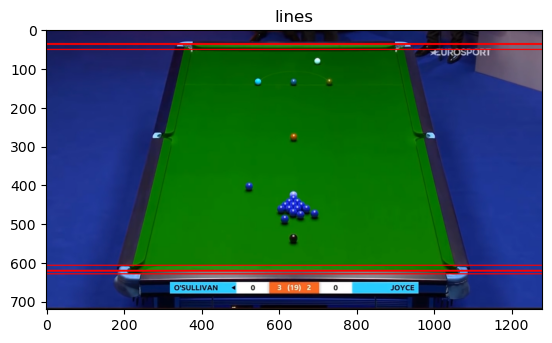

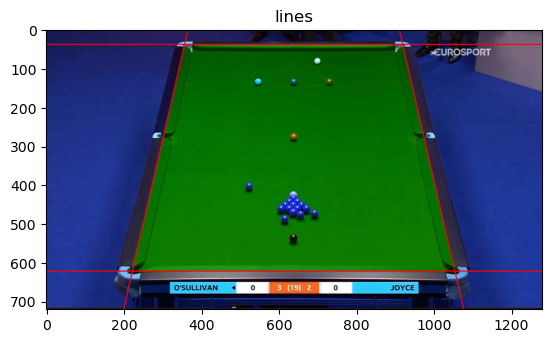

In [4]:
rho_resolution = 1
theta_resolution = np.pi / 180
min_theta = 0
max_theta = np.pi
threshold = 200 



## ####################################
## #####SPLIT VERTICAL AND HORIZ ######
## ####################################

# this function is used to get the lines from the hough space
# we iterate over the edge pixels and for each pixel we calculate the rho value and theta value
def hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution):
    height, width = edges.shape
    diagonal = np.sqrt(height**2 + width**2)

    theta_angles = np.arange(min_theta, max_theta, theta_resolution)
    rho_values = np.linspace(-diagonal, diagonal, int(2 * diagonal / rho_resolution) + 1)

    num_thetas = len(theta_angles)
    num_rhos = len(rho_values)
    accumulator = np.zeros((num_rhos, num_thetas))

    sins = np.sin(theta_angles)
    coss = np.cos(theta_angles)

    y_idxs, x_idxs = np.where(edges > 0)

    for x, y in zip(x_idxs, y_idxs):
        for idx in range(num_thetas):

            rho = x * coss[idx] + y * sins[idx]
            rho_index = np.argmin(np.abs(rho_values - rho))
            accumulator[rho_index, idx] += 1

    idx_rhos, idx_thetas = np.where(accumulator > threshold)
    final_rhos = rho_values[idx_rhos]
    final_thetas = theta_angles[idx_thetas]

    polar_coordinates = np.column_stack((final_rhos, final_thetas))
    return polar_coordinates

# this function is used to filter the vertical and horizontal lines
# we set an angle threshold to filter the lines
def filter_vertical_lines(lines, angle_threshold_deg):
    vertical_lines = []
    horizonal_lines = []
    angle_threshold_rad = np.radians(angle_threshold_deg)
    min_theta = np.pi/2 - angle_threshold_rad
    max_theta = np.pi/2 + angle_threshold_rad
    vertical_lines = [line for line in lines if min_theta <= line[1] <= max_theta]
    horizonal_lines = [line for line in lines if min_theta > line[1] or line[1] > max_theta]
    return np.array(vertical_lines), np.array(horizonal_lines)

# this function is used to adjust the lines to be horizontal
# maibe the lines are not exactly horizontal so we adjust them (is small correction in case)
def adjust_lines_to_horizontal(lines):
    adjusted_lines = []
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        new_rho = y0 
        adjusted_lines.append((new_rho, np.pi / 2))
        
    return np.array(adjusted_lines)


lines = hough_lines(edges, threshold, min_theta, max_theta, rho_resolution, theta_resolution)
horizontal_lines , veritcal_line= filter_vertical_lines(lines, 20)
horizontal_lines = adjust_lines_to_horizontal(horizontal_lines)


# PLot the lines
image_real = cv2.imread(image_path)
for rho, theta in horizontal_lines:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 3000 * (-b))
    y1 = int(y0 + 3000 * (a))
    x2 = int(x0 - 3000 * (-b))
    y2 = int(y0 - 3000 * (a))
    cv2.line(image_real, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(image_real)
plt.title('lines')
plt.show()




## ####################################
#  ##### FILTER TO GET ONLY 4 LINES ###
## ####################################
# get the horizontal line that have  min y at x = 0
# get the horizontal line that have  max y at x = 0
# for the line with max y we get the second max y

# def get_min_max_y_horizontal_lines(lines):
#     min_y = np.inf
#     max_y = -np.inf
#     max_y_2 = -np.inf
#     min_y_line = None
#     max_y_line = None
#     max_y_2_line = None
#     for rho, theta in lines:
#         x0 = rho * np.cos(theta)
#         y0 = rho * np.sin(theta)
#         if y0 < min_y:
#             min_y = y0
#             min_y_line = (rho, theta)
#         if y0 > max_y:
#             max_y_2 = max_y
#             max_y_2_line = max_y_line
#             max_y = y0
#             max_y_line = (rho, theta)
#         elif y0 > max_y_2:
#             max_y_2 = y0
#             max_y_2_line = (rho, theta)

#     return min_y_line, max_y_2_line

def get_min_max_y_horizontal_lines(lines):
    # lines have the form (rho, theta) so we can sort based on y using the rho * np.sin(theta)
    sorted_line_y = sorted(lines, key=lambda x: x[0] * np.sin(x[1]))
    min_y_line = sorted_line_y[2]
    max_y_line = sorted_line_y[len(sorted_line_y) - 2]
    return min_y_line, max_y_line

min_y_line, max_y_line = get_min_max_y_horizontal_lines(horizontal_lines)
horizontal_lines = np.array([min_y_line, max_y_line])

# lover the y value of min_y_line from 2 pixels
min_y_line = (min_y_line[0], min_y_line[1] + np.pi/2)

# get the vertical line that have  min x at y = 0
# get the vertical line that have  max x at y = 0

def get_min_max_x_vertical_lines(lines):
    min_x = np.inf
    max_x = -np.inf
    min_x_line = None
    max_x_line = None
    for rho, theta in lines:
        x0 = rho * np.cos(theta)
        y0 = rho * np.sin(theta)
        if x0 < min_x:
            min_x = x0
            min_x_line = (rho, theta)
        if x0 > max_x:
            max_x = x0
            max_x_line = (rho, theta)
    return min_x_line, max_x_line

min_x_line, max_x_line = get_min_max_x_vertical_lines(veritcal_line)
veritcal_line = np.array([min_x_line, max_x_line])


# merge lines
lines = np.concatenate((horizontal_lines, veritcal_line), axis=0)





## ####################################
## ########         PLOT         ######
## ####################################
image_real = cv2.imread(image_path)

def plot_lines(image, lines, size_line=3000):
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + size_line * (-b))
        y1 = int(y0 + size_line * (a))
        x2 = int(x0 - size_line * (-b))
        y2 = int(y0 - size_line * (a))
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plot_lines(image_real, lines)
plt.imshow(image_real)
plt.title('lines')
plt.show()





# intersection 

The equations of the lines are given in the Hesse normal form:
$\rho = x \cos(\theta) + y \sin(\theta) $
which can be rewritten in matrix form as:
$ A \mathbf{x} = \mathbf{b} $
where $A$ is a matrix of coefficients and $\mathbf{b}$ is a vector of known terms.

For two specific lines, we have:
$
A = \begin{bmatrix}
\cos(\theta_1) & \sin(\theta_1) \\
\cos(\theta_2) & \sin(\theta_2)
\end{bmatrix}, \quad
\mathbf{b} = \begin{bmatrix}
\rho_1 \\
\rho_2
\end{bmatrix}
$

The intersection of these two lines is determined by solving the linear system:
$
\mathbf{x} = A^{-1} \mathbf{b}
$
where $\mathbf{x}$ represents the coordinates $(x, y)$ of the intersection point. This point is calculated using the function $\texttt{np.linalg.solve}$ to solve the system.

Finally, the found intersection points are sorted and managed for further processing.


Intersection Point 1: (222.18, 622.54)
Intersection Point 2: (356.78, 39.50)
Intersection Point 3: (921.06, 39.50)
Intersection Point 4: (1055.66, 622.54)


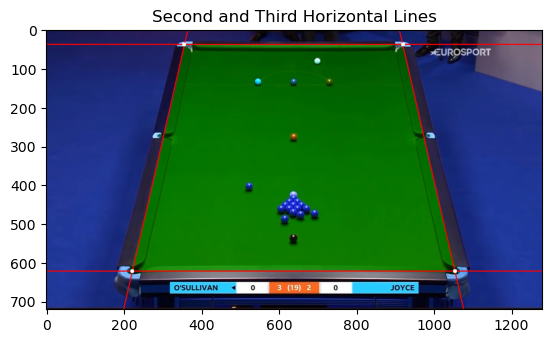

In [5]:
# COMPUTE INTERSECTION POINTS



# Compute intersection points
# every line is defined ρ = x * cos(θ) + y * sin(θ)
# so we can write it as A * x = b
# our system is A x = b
# | cos(θ1) sin(θ1) | x | =  | ρ1 |
# | cos(θ2) sin(θ2) | y |  = | ρ2 |

intersection_points = []
for rho1, theta1 in horizontal_lines:
    for rho2, theta2 in veritcal_line:
        A = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
        b = np.array([rho1, rho2])
        intersection_point = np.linalg.solve(A, b)
        intersection_points.append(intersection_point)

# Sort point to manage more easily
intersection_points.sort(key=lambda x: x[0])
intersection_points_pos = []



## #################################
## #################################

image_path = 'test_image.PNG'  

output_image = cv2.imread(image_path)

# JUST VISUALIZATION
# PLOT LINES AND INTERSECTION POINTS
plot_lines(output_image, lines)

i = 0
for intersection_point in intersection_points:
    x, y = intersection_point
    print(f'Intersection Point {i + 1}: ({x:.2f}, {y:.2f})')
    intersection_points_pos.append((x, y))
    cv2.circle(output_image, (int(x), int(y)), 5, (255, 255, 255), -1)
    i += 1


plt.imshow(output_image)
plt.title('Second and Third Horizontal Lines')
plt.show()

## #################################
## #################################


# Prespective matrix
The function find\_prespective\_transform is designed to compute the perspective transformation matrix that maps a set of four source points pts1 to a set of four destination points (\texttt{pts2}). The process involves setting up and solving a system of linear equations derived from these point correspondences.

The matrix equation can be expressed as:
$ A \mathbf{x} = \mathbf{0} $
where $A$ is an $8 \times 9$ matrix constructed as follows for each point pair $(x, y)$ from \texttt{pts1} and $(u, v)$ from \texttt{pts2}:
$
\begin{array}{c}
\text{For each point pair, two rows are added to } A: \\
\text{Row } 2i: [x, y, 1, 0, 0, 0, -ux, -uy, -u] \\
\text{Row } 2i+1: [0, 0, 0, x, y, 1, -vx, -vy, -v]
\end{array}
$

The solution $\mathbf{x}$, which represents the flattened perspective transformation matrix, is found using the Singular Value Decomposition (SVD) of $A$. Specifically, the solution is given by the last row of the matrix $V$ (from the decomposition $U, S, V = \text{svd}(A)$), reshaped into a $3 \times 3$ matrix. This matrix $M$ is the desired perspective transformation matrix.

This matrix $M$ can then be used to perform perspective warping of images, aligning the source points to the destination points through geometric transformations.


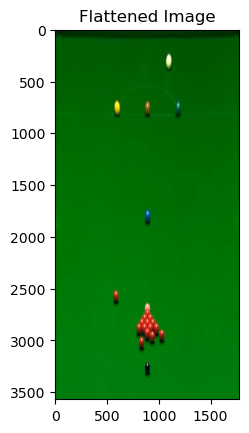

In [6]:
cushions_len = 0.08

def find_prespective_transform(pts1, pts2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = pts1[i]
        u, v = pts2[i]
        A[i * 2] = [x, y, 1, 0, 0, 0, -u * x, -u * y, -u]
        A[i * 2 + 1] = [0, 0, 0, x, y, 1, -v * x, -v * y, -v]
    U, S, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 3)
    return M



# #################################
# #################################
# #################################

# THIS PART IS ONLY FOR VISUALIZATION PURPOSES
# SO WE USE A *1000 FACTOR TO MAKE THE IMAGE BIGGER

cv2.destroyAllWindows()
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] - cushions_len, A[1] + cushions_len)
B = (B[0] - cushions_len, B[1] - cushions_len)
C = (C[0] + cushions_len, C[1] - cushions_len)
D = (D[0] + cushions_len, D[1] + cushions_len)

A = (A[0] * 1000, A[1] * 1000)
B = (B[0] * 1000, B[1] * 1000)
C = (C[0] * 1000, C[1] * 1000)
D = (D[0] * 1000, D[1] * 1000)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)


from PIL import Image

def manual_warp_perspective(image_in, M, out_h, out_w):
    image = image_in.copy()

    output_image = np.zeros((out_h, out_w, 3), dtype=np.uint8)
    
    M_inv = np.linalg.inv(M)
    height, width, _ = image.shape

    for y in range(out_h):
        for x in range(out_w):

            # STEP 1 get homogeneous coordinates
            output_coords = np.array([x, y, 1])

            # STEP 2 apply inverse transformation + normalization
            input_coords = M_inv.dot(output_coords)
            input_coords /= input_coords[2] 

            # STEP 3 add into the final image
            x_in, y_in = int(input_coords[0]), int(input_coords[1])
            output_image[y, x] = image[y_in, x_in]

    return output_image


M_visiva = find_prespective_transform(pts2, pts1)


cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_real = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

out_img = manual_warp_perspective(image_real, M_visiva, 3569, 1778)
plt.imshow(out_img)
plt.title('Flattened Image')
plt.show()

# #################################
# #################################
# #################################


# #################################
# this is the real part and computation of the transformation matrix

A = (0,3.569)
B = (0, 0)
C = (1.778,0)
D = (1.778, 3.569)

A = (A[0] - cushions_len, A[1] + cushions_len)
B = (B[0] - cushions_len, B[1] - cushions_len)
C = (C[0] + cushions_len, C[1] - cushions_len)
D = (D[0] + cushions_len, D[1] + cushions_len)

pts1 = np.float32([A,B,C,D])
pts2 = np.float32(intersection_points_pos)

M = find_prespective_transform(pts2, pts1)
M_inv = np.linalg.inv(M)




# Image Position
just use matrix computed before and find position of our balls in the image

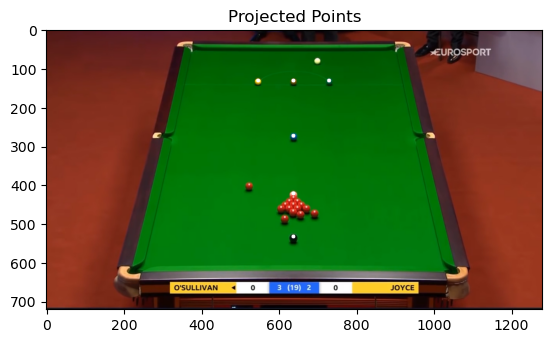

In [7]:
# COMPUTE THE BALL POSITION AND DRAW IT


# first some variable
middle_y = 3.569/2
middle_x = 1.778/2

# (yellow, green, brown, blue, pink, black
points = np.array([
    [middle_x - 0.292, middle_y - 1.0475],  # yellow
    [middle_x + 0.292, middle_y - 1.0475],  # green
    [middle_x, middle_y - 1.0475],          # brown
    [middle_x, middle_y],                   # blue
    [middle_x, middle_y + 0.89225],         # pink
    [middle_x, middle_y + 1.4605]           # black
])


# Apply transformation 

# Like for image but with points
def apply_transformation_to_points(points, M):
    transformed_points = []
    for point in points:
        #print(point)
        point_homog = np.array([point[0], point[1], 1])
        transformed_point = np.dot(np.linalg.inv(M), point_homog) 
        transformed_point /= transformed_point[2] 
        transformed_points.append(transformed_point[:2])
    return np.array(transformed_points)

projected_points = apply_transformation_to_points(points, M)


# #################################
# #################################
# JUST VISUALIZATION TO CHECK IF BALLS ARE CORRECT

cv2.destroyAllWindows()
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# draw points
output_image = image_rgb.copy()
for point in projected_points:

    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)


# show image
plt.imshow(output_image)
plt.title('Projected Points')
plt.show()

# #################################
# #################################
# #################################


# Area table
just subtract from world coordinate the cushions, compute image coordinate and compute area in pixels x pixels

Area of the table is 355490.45780633163 m^2


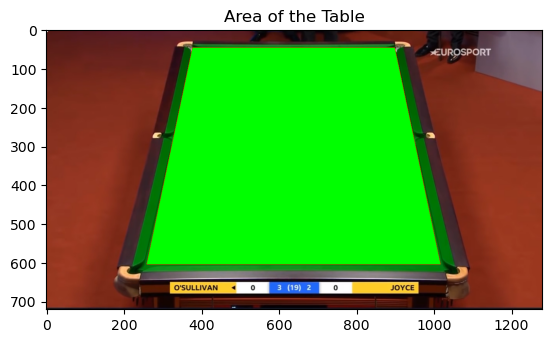

In [8]:
# Area of table

A_2 = (0,3.569)
B_2 = (0,0)
C_2 = (1.778,0)
D_2 = (1.778, 3.569)

new_angle_pts = np.float32([A_2,B_2,C_2,D_2])
new_angle_pts = apply_transformation_to_points(new_angle_pts, M)

A_2_new = new_angle_pts[0]
B_2_new = new_angle_pts[1]
C_2_new = new_angle_pts[2]
D_2_new = new_angle_pts[3]

larger_base = D_2_new[0] - A_2_new[0] 
small_base = C_2_new[0] - B_2_new[0]
height = A_2_new[1] - B_2_new[1]


Area = (larger_base+small_base) * height/2

print(f'Area of the table is {Area} m^2')

# #################################
# plot the area in green with plt
# #################################


output_image = image_rgb.copy()
for i in range(4):
    cv2.line(output_image, (int(new_angle_pts[i][0]), int(new_angle_pts[i][1])), (int(new_angle_pts[(i + 1) % 4][0]), int(new_angle_pts[(i + 1) % 4][1])), (255, 0, 0), 2)
    cv2.fillPoly(output_image, np.array([new_angle_pts], dtype=np.int32), (0, 255, 0, 100))

cv2.circle(output_image, (int(A[0]), int(A[1])), 5, (255, 255, 255), -1)
plt.imshow(output_image)
plt.title('Area of the Table')
plt.show()






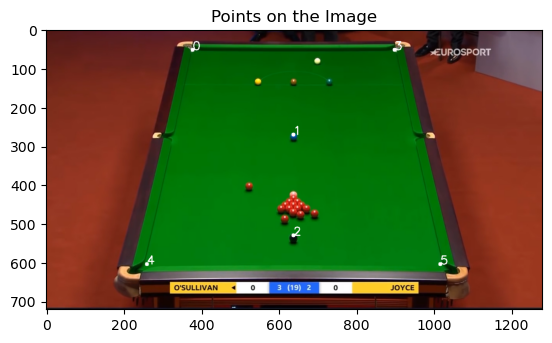

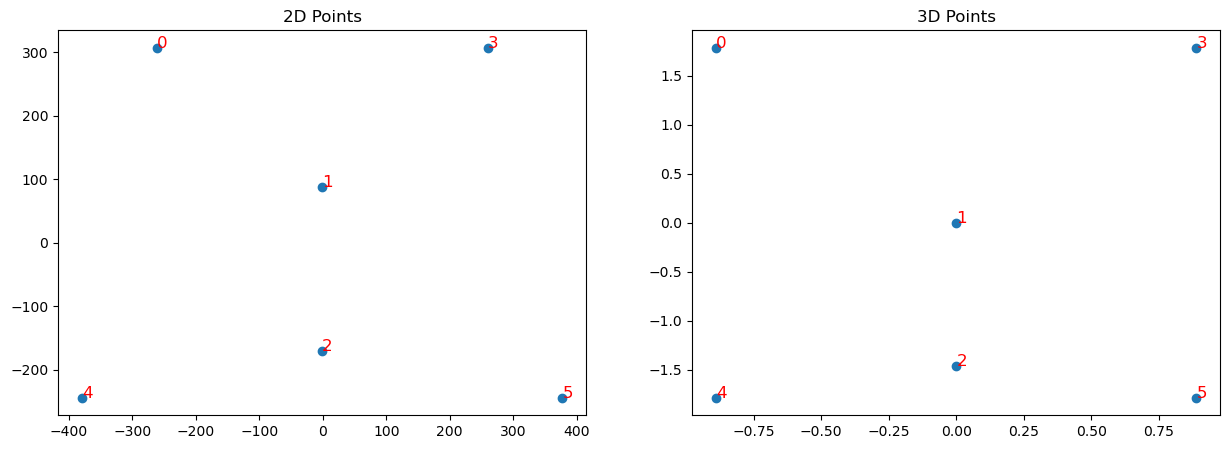

All points are equal
Equal KR = M_3x3: False
rank A: 11
Camera Position: [-3.60553587e-10 -2.60144706e+00  3.45688762e+00]
Camera Position: [-3.60553587e-10 -2.60144706e+00  3.45688762e+00]
Equal: True
Equal C in nullspace: True
Camera Position: [-3.60553587e-10 -2.60144706e+00  3.45688762e+00]


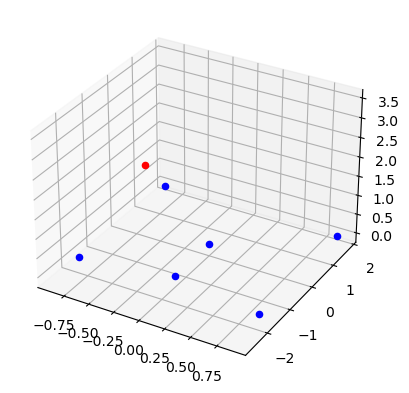

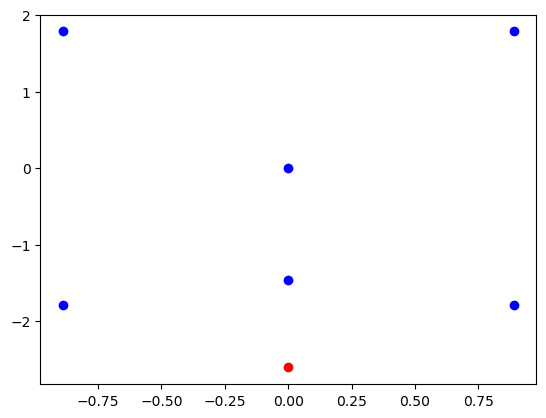

In [9]:
DEBUG = True
# Step 1: get world coordinates and pixel coordinates
# this are our corner in the real world
# for world coords we use 4 corners in the playng area and the 2 balls
A_2 = (0,0)
B_2 = (middle_x, middle_y)
C_2 = (middle_x, middle_y + 1.4605)
D_2 = (1.778,0)
A = (0,3.569)
B = (1.778,3.569 )



world_coords = np.array([
    A_2,
    B_2,
    C_2,
    D_2,
    A,
    B,
])

pixel_coords = apply_transformation_to_points(world_coords, M)

# change y of pixel_coords[3] an pixel_coords[0] + 5 pixel this is because top corner are not so perfect and DLT is sensitive small error
pixel_coords[3][1] = pixel_coords[3][1] + 5
pixel_coords[0][1] = pixel_coords[0][1] + 5
# also ball, we have a pint not perfect in center so we correct the y
pixel_coords[2][1] = pixel_coords[2][1] - 3
pixel_coords[1][1] = pixel_coords[1][1] - 3

# plot on the image the points
output_image = image_rgb.copy()
for i, point in enumerate(pixel_coords):
    cv2.circle(output_image, (int(point[0]), int(point[1])), 5, (255, 255, 255), -1)
    cv2.putText(output_image, str(i), (int(point[0]), int(point[1])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

plt.imshow(output_image)
plt.title('Points on the Image')
plt.show()

# Step 2: make the world coordinates 3D, so add Z 0.8 for the table and 0.8 + 0.02625

TRABLE_HEIGHT =0.0 # 0.8

world_coords_3d = np.array([
    [A_2[0], A_2[1], TRABLE_HEIGHT],
    [B_2[0], B_2[1], TRABLE_HEIGHT + 0.02625*2],  
    [C_2[0], C_2[1], TRABLE_HEIGHT+ 0.02625*2],
    [D_2[0], D_2[1], TRABLE_HEIGHT],
    [A[0], A[1], TRABLE_HEIGHT],
    [B[0], B[1], TRABLE_HEIGHT],
])


# spe 2.5 center of the table x and y for 2d and 3d and flip the y axis

world_coords_3d[:, 0] = world_coords_3d[:, 0] - 1.778/2
world_coords_3d[:, 1] = world_coords_3d[:, 1] - 3.569/2
pixel_coords[:, 0] = pixel_coords[:, 0]- image.shape[1]/2 
pixel_coords[:, 1] = pixel_coords[:, 1]- image.shape[0]/2 

pixel_coords[:, 1] = -pixel_coords[:, 1]
world_coords_3d[:, 1] = -world_coords_3d[:, 1]



fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].scatter(pixel_coords[:, 0], pixel_coords[:, 1])
axs[0].set_title('2D Points')
for i, point in enumerate(pixel_coords):
    axs[0].text(point[0], point[1], str(i), fontsize=12, color='red')
axs[1].scatter(world_coords_3d[:, 0], world_coords_3d[:, 1])
axs[1].set_title('3D Points')
for i, point in enumerate(world_coords_3d):
    axs[1].text(point[0], point[1], str(i), fontsize=12, color='red')
plt.show()





# Step 3: compute the camera matrix using DLT

def compute_camera_matrix(world_coords, pixel_coords):
    # step 1 : compute A matrix
    A = np.zeros((2 * len(world_coords), 12))
    for i in range(len(world_coords)):
        X, Y, Z = world_coords[i]
        u, v = pixel_coords[i]
        A[2 * i] = [-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u]
        A[2 * i + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, v * X, v * Y, v * Z, v]

    # step 2 : compute SVD
    U, S, V = np.linalg.svd(A)
    M = V[-1].reshape(3, 4)
    return M

# return P matrix but in homogenous coordinates 3x4
def compute_camera_matrix_Hom(world_coords, pixel_coords):
    # step 1 : compute A matrix
    A = np.zeros((2 * len(world_coords), 12))
    for i in range(len(world_coords)):
        X, Y, Z = world_coords[i]
        u, v = pixel_coords[i]
        A[2 * i] = [-X, -Y, -Z, -1, 0, 0, 0, 0, u * X, u * Y, u * Z, u]
        A[2 * i + 1] = [0, 0, 0, 0, -X, -Y, -Z, -1, v * X, v * Y, v * Z, v]

    if DEBUG:
        print(f'rank A: {np.linalg.matrix_rank(A)}')

    # step 2 : compute SVD
    U, S, V = np.linalg.svd(A)
    return V[-1].reshape(3, 4)

M_camera = compute_camera_matrix(world_coords_3d, pixel_coords)


# #################################
# CHECK IF THE POINTS ARE EQUAL
if DEBUG:
    flag = True
    for i in range(len(world_coords_3d)):
        point_3d = np.array([world_coords_3d[i][0], world_coords_3d[i][1], world_coords_3d[i][2], 1])
        point_2d = M_camera.dot(point_3d)
        point_2d /= point_2d[2]
        # if not eqal brake and print ERROR
        if not np.allclose(point_2d[:2], pixel_coords[i]):
            print(f'ERROR: {point_2d[:2]} != {pixel_coords[i]}')
            flag = False
            break
    if flag:
        print('All points are equal')



# Step 4: decompose the camera matrix to get the intrinsic and extrinsic parameters


def decompose_camera_matrix(M):
    M3x3 = M[:, :3]
    Q, R = np.linalg.qr(np.linalg.inv(M3x3))
    
    # Correcting signs for positive diagonal in K
    T = np.diag(np.sign(np.diag(R)))
    K = np.dot(R, T)
    R = np.dot(np.linalg.inv(T), Q)
    
    return K, R.T



K, R = decompose_camera_matrix(M_camera)

if DEBUG:
    # check if K and R give our P matrix
    M_3x3 = M_camera[:, :3]
    KR = K.dot(R)
    print(f'Equal KR = M_3x3: {np.allclose(KR, M_3x3)}')
    
    
# final step compute camera position

def compute_camera_position(M):
    M_3x3 = M[:, :3]
    M_4 = M[:, 3]
    C = -np.linalg.inv(M_3x3).dot(M_4)
    return C

def compute_camera_pos_hom(M):
    # X:= Determinant(<p2|p3|p4>): Y:=-Determinant(<p1|p3|p4>): Z:= Determinant(<p1|p2|p4>): W:=-Determinant(<p1|p2|p3>):
    # > C:=<X/W,Y/W,Z/W>;
    p1 = M[:, 0]
    p2 = M[:, 1]
    p3 = M[:, 2]
    p4 = M[:, 3]

    X = np.linalg.det(np.column_stack((p2, p3, p4)))
    Y = -np.linalg.det(np.column_stack((p1, p3, p4)))
    Z = np.linalg.det(np.column_stack((p1, p2, p4)))
    W = -np.linalg.det(np.column_stack((p1, p2, p3)))

    return np.array([X/W, Y/W, Z/W])


C = compute_camera_position(M_camera)

M_hom = compute_camera_matrix_Hom(world_coords_3d, pixel_coords)
C_2 = compute_camera_pos_hom(M_hom)

if DEBUG:
    print(f'Camera Position: {C}')
    print(f'Camera Position: {C_2}')
    print(f'Equal: {np.allclose(C, C_2)}')


if DEBUG:
    # check if C is in the nullspace of the P
    print(f'Equal C in nullspace: {np.allclose(M_camera.dot(np.array([C[0], C[1], C[2], 1])), 0)}')


print(f'Camera Position: {C}')

# plot in 3D

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot the camera position and world coordinates
ax.scatter(C[0], C[1], C[2], c='r', marker='o')
for i in range(len(world_coords_3d)):
    ax.scatter(world_coords_3d[i][0], world_coords_3d[i][1], world_coords_3d[i][2], c='b', marker='o')

plt.show()

# show only x and y in 2D
fig, ax = plt.subplots()
ax.scatter(C[0], C[1], c='r', marker='o')
for i in range(len(world_coords_3d)):
    ax.scatter(world_coords_3d[i][0], world_coords_3d[i][1], c='b', marker='o')
plt.show()






# Find ball positions
A threshold is computed based on the lightness of the image, then each connected component on the threshold corresponds to a ball 

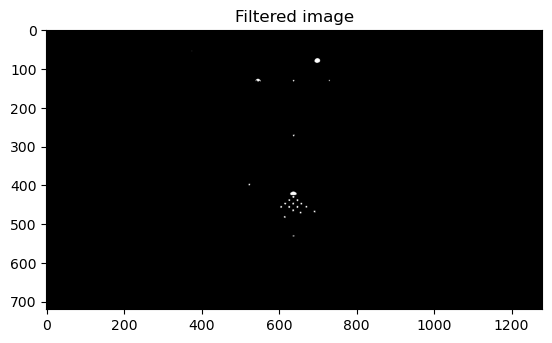

In [10]:
image_grayscale = np.average(image, axis=2)
image_grayscale = np.where(image_grayscale > 170, 255, 0)
temp = np.zeros(image_grayscale.shape)
cv2.fillPoly(temp, np.array([new_angle_pts], dtype=np.int32), 1)
image_grayscale = np.where(temp > 0, image_grayscale, 0)
plt.imshow(image_grayscale, cmap='gray')
plt.title('Filtered image')
plt.show()

In [11]:
def find_ranges(data):
    ranges = []
    m = len(data)
    start = data[0]
    curr = start
    for i in range(m-1):
        if data[i] == curr:
            curr += 1
        else:
            ranges.append((start,data[i-1]))
            start = data[i]
            curr = start+1
    ranges.append((start,data[m-1]))
    return ranges

In [13]:
white_points_x = np.nonzero(np.sum(image_grayscale, axis=0))[0]
white_points_y = np.nonzero(np.sum(image_grayscale, axis=1))[0]
white_points_x = find_ranges(white_points_x)
white_points_y = find_ranges(white_points_y)
if white_points_x[0][0] == white_points_x[0][1] and white_points_y[0][0] == white_points_y[0][1]:
    white_points_x = white_points_x[1:]
    white_points_y = white_points_y[1:]

centroids = []
for i in white_points_x:
    for j in white_points_y:
        if np.sum(image_grayscale[j[0]:j[1],i[0]:i[1]] != 0):
            image_grayscale_2 = np.zeros(image_grayscale.shape)
            image_grayscale_2[j[0]:j[1],i[0]:i[1]] = image_grayscale[j[0]:j[1],i[0]:i[1]]
            white_points_x_2 = np.nonzero(np.sum(image_grayscale_2, axis=0))[0]
            white_points_y_2 = np.nonzero(np.sum(image_grayscale_2, axis=1))[0]
            white_points_x_2 = find_ranges(white_points_x_2)
            white_points_y_2 = find_ranges(white_points_y_2)
            for i2 in white_points_x_2:
                for j2 in white_points_y_2:
                    if np.sum(image_grayscale_2[j2[0]:j2[1],i2[0]:i2[1]] != 0):
                        centroids.append([(i2[0]+i2[1])//2,(j2[0]+j2[1])//2])

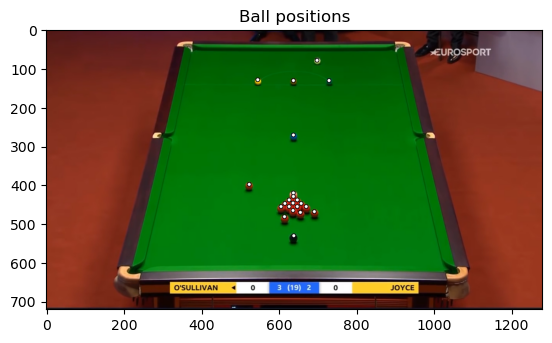

In [14]:
new_image = image_rgb.copy()
for i, point in enumerate(centroids):
    cv2.circle(new_image, (int(point[0]), int(point[1])), 6, (0, 0, 0), -1)
    cv2.circle(new_image, (int(point[0]), int(point[1])), 4, (255, 255, 255), -1)
plt.imshow(new_image)
plt.title('Ball positions')
plt.show()